## Packages

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import os

import collections
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import print_noise_matrix
from cleanlab import baseline_methods
from cleanlab.latent_estimation import compute_confident_joint

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def acc_loss_plot(network):
    accuracy = network.history['accuracy']
    val_accuracy = network.history['val_accuracy']
    loss = network.history['loss']
    val_loss = network.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'c', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Lectura de les dades

In [3]:
print(tf. __version__)

2.6.0


In [4]:
os.getcwd()

'C:\\Users\\aidaf\\TFG'

In [5]:
data_dir = os.path.join(os.getcwd() + "\\reduced")
data_dir

'C:\\Users\\aidaf\\TFG\\reduced'

In [6]:
classes = os. listdir(data_dir)
print(classes)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [7]:
dades_Y_clean = np.load('labels_reduced_clean_train.npy')
dades_X_clean = np.load('images_reduced_clean_train.npy')

dades_Y_resta = np.load('labels_reduced_train.npy')
dades_X_resta = np.load('images_reduced_train.npy')

In [8]:
clean_Y = np.load('labels_reduced_clean.npy')
clean_X = np.load('images_reduced_clean.npy')

clean_X.shape, clean_Y.shape

((500, 120, 120, 3), (500,))

## Descripció de les dades

Dimensió: 

In [9]:
print('Dimensions de les dades : ', dades_X_clean.shape, dades_Y_clean.shape)
print('Dimensions de les dades : ', dades_X_resta.shape, dades_Y_resta.shape)

Dimensions de les dades :  (1000, 120, 120, 3) (1000,)
Dimensions de les dades :  (3500, 120, 120, 3) (3500,)


Nombre de classes i etiquetes: 

In [10]:
n_classes = len(classes)
print('Nombre de classes : ', n_classes)
print('Etiquetes de les classes : ', classes)

Nombre de classes :  5
Etiquetes de les classes :  ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Distribució de les classes: 

In [11]:
print("Distribució de les classes : ",collections.Counter(dades_Y_clean))
print("Distribució de les classes : ",collections.Counter(dades_Y_resta))

Distribució de les classes :  Counter({0: 200, 4: 200, 3: 200, 1: 200, 2: 200})
Distribució de les classes :  Counter({2: 700, 3: 700, 4: 700, 0: 700, 1: 700})


# Augmentem encara més el soroll

In [12]:
noise_matrix = np.array([[.7,.2,.04,.03,.03],
                         [.2,.7,.04,.03,.03],
                         [.05,.01,.68,.13,.13],
                         [.01,.02,.12,.7,.15],
                         [.04,.04,.17,.05,.7]])

np.sum(noise_matrix,1) == 1

array([ True,  True,  True,  True,  True])

In [13]:
print_noise_matrix(noise_matrix)
np.random.seed(seed=1)
# Create the noisy labels. This method is exact w.r.t. the noise_matrix.
y_train_w_errors = generate_noisy_labels(dades_Y_resta, noise_matrix)


print("------------------------------------------------------")
print("% d'etiquetes netes: ",sum(y_train_w_errors == dades_Y_resta)/len(dades_Y_resta))

print("------------------------------------------------------")

dades_Y_one_hot = np.array(pd.get_dummies(dades_Y_clean))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')

train_X,valid_X,train_label,valid_label = train_test_split(dades_X_clean, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))


 Noise Matrix (aka Noisy Channel) P(s|y) of shape (5, 5)
 p(s|y)	y=0	y=1	y=2	y=3	y=4
	---	---	---	---	---
s=0 |	0.7	0.2	0.04	0.03	0.03
s=1 |	0.2	0.7	0.04	0.03	0.03
s=2 |	0.05	0.01	0.68	0.13	0.13
s=3 |	0.01	0.02	0.12	0.7	0.15
s=4 |	0.04	0.04	0.17	0.05	0.7
	Trace(matrix) = 3.48

------------------------------------------------------
% d'etiquetes netes:  0.696
------------------------------------------------------
(900, 120, 120, 3) (100, 120, 120, 3) (900, 5) (100, 5)
------------------------------------------------------
Distribució de les classes :  Counter({3: 742, 1: 721, 0: 700, 4: 672, 2: 665})


In [14]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X_clean.shape[1],dades_X_clean.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 64

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [15]:
# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/20
15/15 [==============================] - 35s 2s/step - loss: 1.8057 - accuracy: 0.3278 - val_loss: 1.1092 - val_accuracy: 0.4000
Epoch 2/20
15/15 [==============================] - 31s 2s/step - loss: 1.0047 - accuracy: 0.5011 - val_loss: 0.7688 - val_accuracy: 0.5700
Epoch 3/20
15/15 [==============================] - 31s 2s/step - loss: 0.9229 - accuracy: 0.5889 - val_loss: 0.6555 - val_accuracy: 0.6800
Epoch 4/20
15/15 [==============================] - 31s 2s/step - loss: 0.7510 - accuracy: 0.6500 - val_loss: 0.6169 - val_accuracy: 0.6700
Epoch 5/20
15/15 [==============================] - 31s 2s/step - loss: 0.7339 - accuracy: 0.6578 - val_loss: 0.6932 - val_accuracy: 0.6000
Epoch 6/20
15/15 [==============================] - 31s 2s/step - loss: 0.7375 - accuracy: 0.6444 - val_loss: 0.8050 - val_accuracy: 0.6600
Epoch 7/20
15/15 [==============================] - 31s 2s/step - loss: 0.6639 - accuracy: 0.7022 - val_loss: 0.5567 - val_accuracy: 0.7200
Epoch 8/20
15/15 [==

In [16]:
model.save("model_70_subset.h5")

In [17]:
def_model = keras.models.load_model('model_70_subset.h5')
test_eval = def_model.evaluate(valid_X,valid_label, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5329759120941162
Test accuracy: 0.8100000023841858


In [18]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

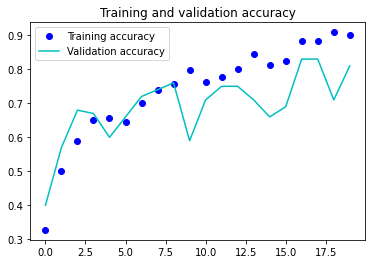

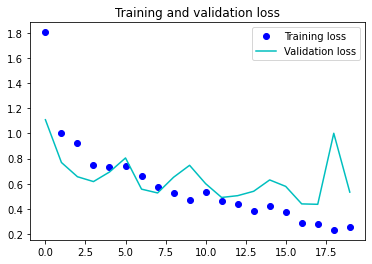

In [19]:
acc_loss_plot(H)

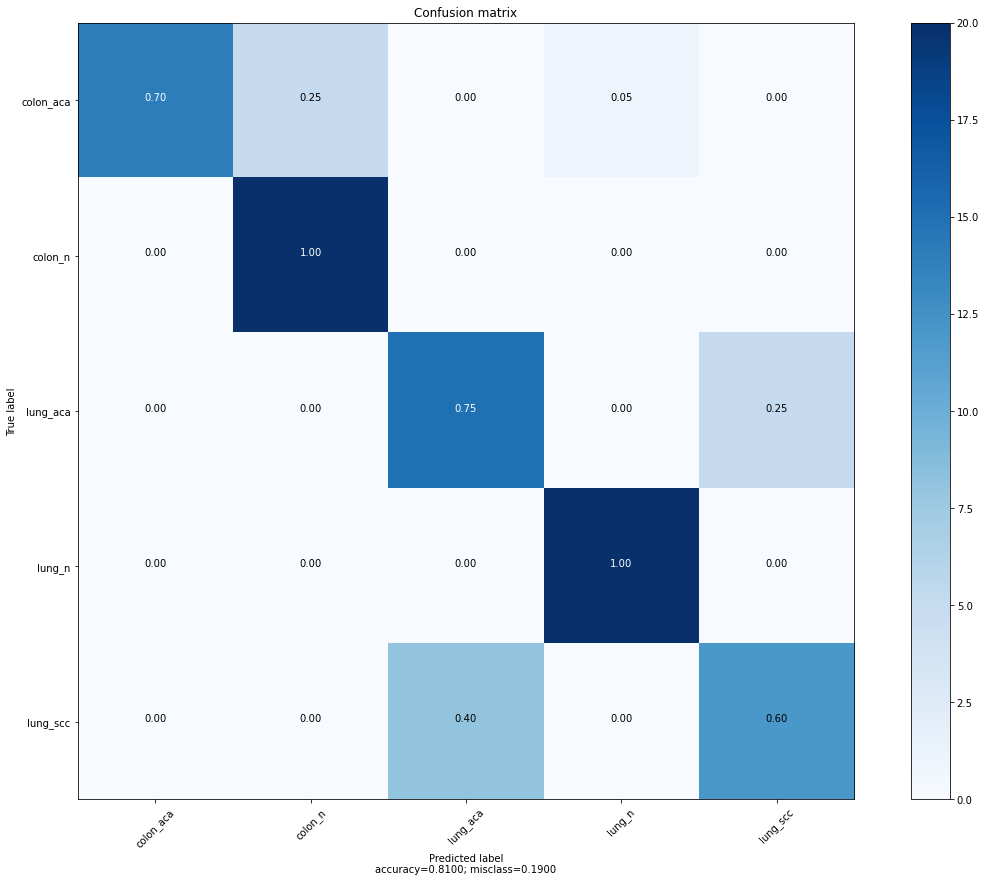

In [20]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

In [21]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       1.00      0.70      0.82        20
     colon_n       0.80      1.00      0.89        20
    lung_aca       0.65      0.75      0.70        20
      lung_n       0.95      1.00      0.98        20
    lung_scc       0.71      0.60      0.65        20

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



## Demanem al model que digui quines prediccions són errónies

In [22]:
prediccions = def_model.predict(dades_X_resta)
prediccions = np.argmax(np.round(prediccions),axis=1)

In [23]:
print(sum(prediccions == dades_Y_resta)/len(prediccions),
1 - sum(prediccions == dades_Y_resta)/len(prediccions))

0.8051428571428572 0.19485714285714284


El model indica que un 87% de les nostres etiquetes són correctes però que un 13% són noisy labels.

In [24]:
new_Y = np.concatenate((dades_Y_clean, prediccions),axis = 0)
new_X = np.concatenate((dades_X_clean, dades_X_resta),axis = 0)

print(new_X.shape,new_Y.shape)

(4500, 120, 120, 3) (4500,)


In [25]:
dades_Y_one_hot = np.array(pd.get_dummies(new_Y))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')

train_X,valid_X,train_label,valid_label = train_test_split(new_X, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=new_Y)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(new_Y))

(4050, 120, 120, 3) (450, 120, 120, 3) (4050, 5) (450, 5)
------------------------------------------------------
Distribució de les classes :  Counter({1: 1090, 2: 987, 3: 890, 4: 830, 0: 703})


In [26]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X_clean.shape[1],dades_X_clean.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 64

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [27]:
# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/20
64/64 [==============================] - 129s 2s/step - loss: 0.9335 - accuracy: 0.5862 - val_loss: 0.6926 - val_accuracy: 0.6378
Epoch 2/20
64/64 [==============================] - 137s 2s/step - loss: 0.4880 - accuracy: 0.7847 - val_loss: 0.4032 - val_accuracy: 0.8422
Epoch 3/20
64/64 [==============================] - 137s 2s/step - loss: 0.3814 - accuracy: 0.8440 - val_loss: 0.3193 - val_accuracy: 0.8933
Epoch 4/20
64/64 [==============================] - 136s 2s/step - loss: 0.3466 - accuracy: 0.8523 - val_loss: 0.4562 - val_accuracy: 0.8444
Epoch 5/20
64/64 [==============================] - 138s 2s/step - loss: 0.2613 - accuracy: 0.9025 - val_loss: 0.2873 - val_accuracy: 0.9044
Epoch 6/20
64/64 [==============================] - 137s 2s/step - loss: 0.1800 - accuracy: 0.9309 - val_loss: 0.3964 - val_accuracy: 0.8733
Epoch 7/20
64/64 [==============================] - 128s 2s/step - loss: 0.1864 - accuracy: 0.9274 - val_loss: 0.4217 - val_accuracy: 0.8622
Epoch 8/20
64

In [28]:
model.save("model_70_reetiquetat.h5")

In [29]:
def_model_2 = keras.models.load_model('model_70_reetiquetat.h5')
test_eval = def_model_2.evaluate(valid_X,valid_label, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.574600875377655
Test accuracy: 0.8866666555404663


In [30]:
predicted_classes = def_model_2.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

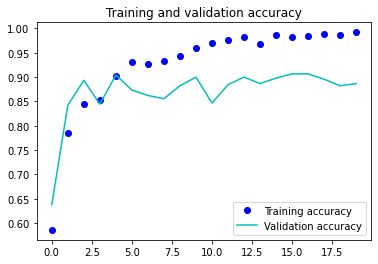

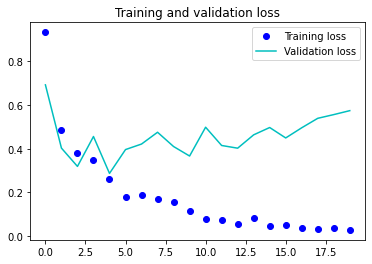

In [31]:
acc_loss_plot(H)

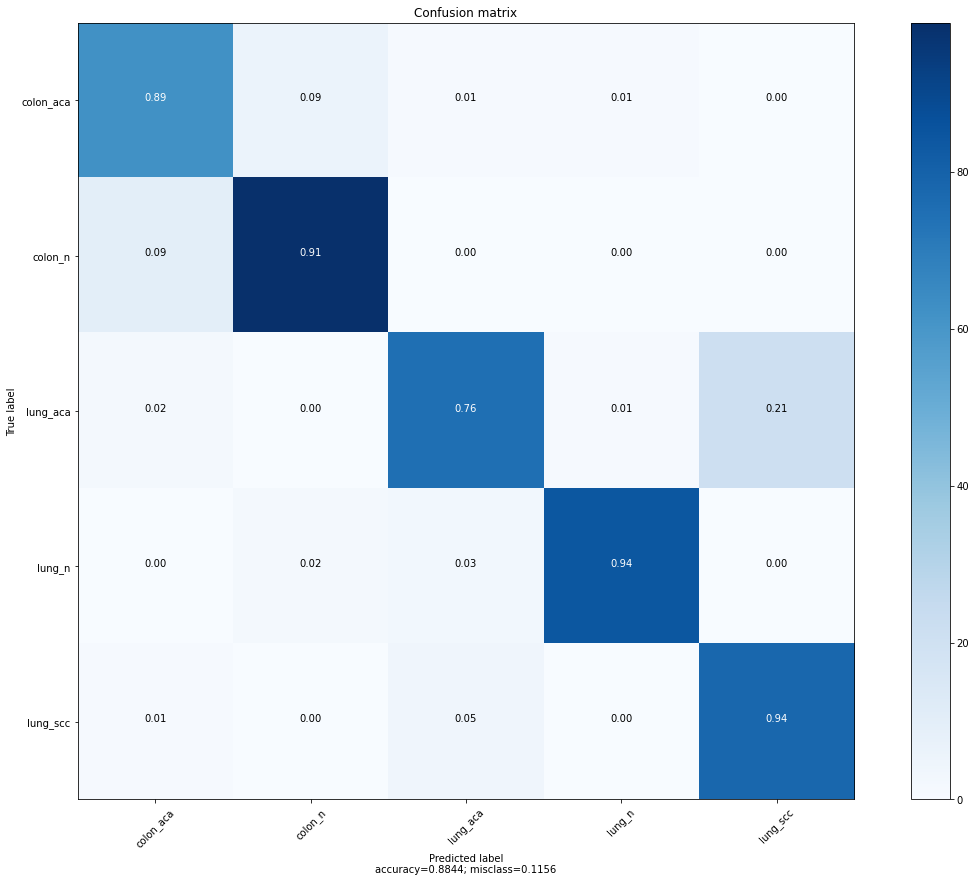

In [32]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

In [33]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.83      0.89      0.86        70
     colon_n       0.93      0.91      0.92       109
    lung_aca       0.90      0.76      0.82        99
      lung_n       0.98      0.94      0.96        89
    lung_scc       0.79      0.94      0.86        83

    accuracy                           0.88       450
   macro avg       0.88      0.89      0.88       450
weighted avg       0.89      0.88      0.88       450



### Comprovem com va classificar el model inicial entrenat amb les dades errònies

In [34]:
def_model_original = keras.models.load_model('model_70.h5')

In [35]:
prediction = def_model_original.predict(clean_X)
pred_labs_original = []

for i in range(len(prediction)):
    pred_labs_original.append(np.argmax(prediction[i]))

In [36]:
sum(pred_labs_original == clean_Y)/len(clean_Y)

0.642

### Comprovem com ho fa el model entrenat amb base de dades petita en la base de dades neta

In [37]:
prediction = def_model.predict(clean_X)
pred_labs_mini = []

for i in range(len(prediction)):
    pred_labs_mini.append(np.argmax(prediction[i]))

In [38]:
sum(pred_labs_mini == clean_Y)/len(clean_Y)

0.814

### Comprovem com ho fa el model entrenat en la base de dades completa amb les reetiquetacions en la base de dades neta

In [39]:
prediction = def_model_2.predict(clean_X)
pred_labs_reetiquetat = []

for i in range(len(prediction)):
    pred_labs_reetiquetat.append(np.argmax(prediction[i]))

In [40]:
sum(pred_labs_reetiquetat == clean_Y)/len(clean_Y)

0.796

models de teacher student buscar